# procedure - G Simulación del experimental de calibración del modulador


We develop experiment 
" Moreno, I., Velásquez, P., Fernández-Pousa, C. R., Sánchez-López, M. M. & Mateos, F. Jones matrix method for predicting and optimizing the optical modulation properties of a liquid-crystal display. J. Appl. Phys. 94, 3697–3702 (2003)."

## Load

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize']= [5.0, 5.0]
matplotlib.rcParams['image.cmap']= 'seismic'
matplotlib.rcParams['image.interpolation']= 'bilinear'
matplotlib.rcParams['image.origin']= 'lower'

In [3]:
from numpy import pi

In [4]:
from py_pol.jones_matrix import Jones_matrix
from py_pol.jones_vector import Jones_vector

In [5]:
from slm import np, sp, plt, um, mm, degrees
from slm.LCD_jones_matrices import LCD_jones_matrices, get_fields_gl, get_LUT_amplitude, get_LUT_phases
from slm.LCD_models import LCD_kopin

ModuleNotFoundError: No module named 'slm'

## Polarizers angles

In [6]:
angles=np.zeros((7,4), dtype=float)

angles[0,:]=(0,       0,       0,      0)
angles[1,:]=(0,       0,    pi/2,      pi/2)
angles[2,:]=(0,       0,    pi/4,      0)
angles[3,:]=(0,       pi/4, pi/2,      pi/2)
angles[4,:]=(pi/4,    pi/4,    0,      0)
angles[5,:]=(pi/4,    pi/4, pi/2,      pi/2)
angles[6,:]=(0,       0,    pi/4,      pi/4)


## Polarization elements

In [7]:
source = Jones_vector()
source.circular_light();

In [8]:
P1 = Jones_matrix('m1')
Q1 = Jones_matrix('m2')
Q2 = Jones_matrix('m3')
P2 = Jones_matrix('m4')

## Parameters from theoretical model

In [9]:
LCD_model=LCD_kopin
LCD_experiment = LCD_jones_matrices(LCD_model)
LCD_theoretical_matrices = LCD_experiment.DC()
LCD_jones = LCD_experiment.DC_to_pypol()

gl=LCD_model['gl']
num_gl = len(gl)

In [10]:
LCD_jones.remove_global_phase()
gp = np.angle(LCD_jones.M[1,1,:])
LCD_jones.set_global_phase(-gp/2);

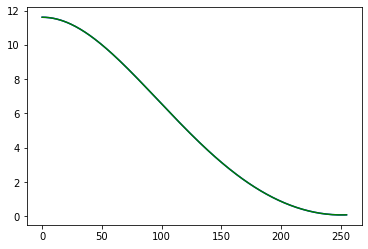

In [11]:
angle1 = -np.angle(LCD_jones.M[0,0,:])
angle2 = np.angle(LCD_jones.M[1,1,:])
plt.plot(angle1/degrees, 'b')
plt.plot(angle2/degrees, 'g')

In [12]:
J00_teo = LCD_jones.M[0,0,:]
J01_teo = LCD_jones.M[0,1,:]
J10_teo = LCD_jones.M[1,0,:]
J11_teo = LCD_jones.M[1,1,:]

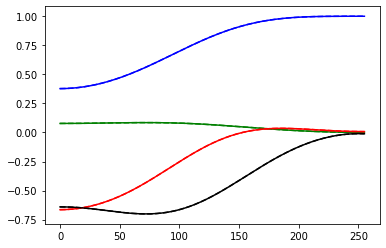

In [13]:
X_teo=np.real(J00_teo)
Y_teo=-np.imag(J00_teo)
Z_teo=np.real(J01_teo)
W_teo=-np.imag(J01_teo)
X2_teo=np.real(J11_teo)
Y2_teo=np.imag(J11_teo)
Z2_teo=-np.real(J10_teo)
W2_teo=-np.imag(J10_teo)

plt.plot(X_teo, 'b')
plt.plot(Y_teo, 'g')
plt.plot(X2_teo, 'b--')
plt.plot(Y2_teo, 'g--')
plt.plot(Z_teo, 'r')
plt.plot(W_teo, 'k')
plt.plot(Z2_teo, 'r--')
plt.plot(W2_teo, 'k--')

## Determinante de la matriz teórica

The determinant of SLM is:
The mean value is (1-2.0369533018866147e-16j) +- 5.622952650459251e-16


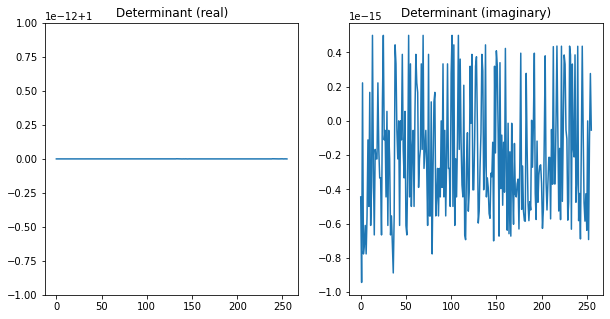

In [14]:
det_teo=np.abs(LCD_jones.parameters.det(draw=True))

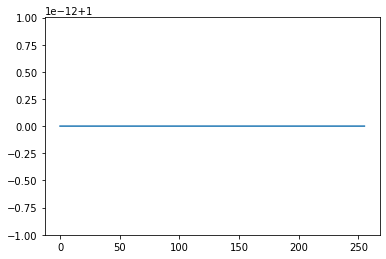

In [15]:
plt.plot(X_teo**2+Y_teo**2+Z_teo**2+W_teo**2)

## Get intensities

Primero voy a usar una única matriz.

In [16]:
J = LCD_jones[0]

P1.diattenuator_perfect(azimuth=angles[:,0])
Q1.quarter_waveplate(azimuth=angles[:,1])
Q2.quarter_waveplate(azimuth=angles[:,2])
P2.diattenuator_perfect(azimuth=angles[:,3])

Ef = P2 * Q2 * J * Q1 * P1 * source
I = Ef.parameters.intensity()
P1.diattenuator_perfect(azimuth=0)

Ef2 = P1 * P1 * source
I = I / Ef2.parameters.intensity()

In [17]:
X2 = I[0] / (1 + ((I[6]-I[5])/(I[2]-I[3]))**2)
Y2 = I[0] / (1 + ((I[2]-I[3])/(I[6]-I[5]))**2)
Z2 = I[1] / (1 + ((I[2]-I[3])/(I[4]-I[6]))**2)
W2 = I[1] / (1 + ((I[4]-I[6])/(I[2]-I[3]))**2)
X = np.sqrt(X2)
Y = np.sqrt(Y2)
Z = np.sqrt(Z2)
W = np.sqrt(W2)
sZ = np.sign(I[4] - I[6])
sW = np.sign(I[2] - I[3])
sY = np.sign(I[6] - I[5]) / sW

In [18]:
print('Resultado:')
print('- X. Teórico:   {}; Experimental   {}'.format(X_teo[0], X))
print('- Y. Teórico:   {}; Experimental   {}'.format(Y_teo[0], sY*Y))
print('- Z. Teórico:   {}; Experimental   {}'.format(Z_teo[0], sZ*Z))
print('- W. Teórico:   {}; Experimental   {}'.format(W_teo[0], sW*W))

Resultado:
- X. Teórico:   0.3772627827900118; Experimental   0.3772627827900118
- Y. Teórico:   0.07749322248172576; Experimental   0.0774932224817257
- Z. Teórico:   -0.664525783064533; Experimental   -0.6645257830645336
- W. Teórico:   -0.6403694846207176; Experimental   -0.6403694846207172


Para uno solo y usando las ecuaciones tal y como las tenia en mi documento funciona. Vamos a ver para todos a la vez, que lo tengo que adaptar.

In [19]:
I = np.zeros((7,256), dtype=float)

for i, angles_i in enumerate(angles):
    angle1, angle2, angle3, angle4 = angles_i
    
    P1.diattenuator_perfect(azimuth=angle1, length=num_gl)
    Q1.quarter_waveplate(azimuth=angle2, length=num_gl)
    Q2.quarter_waveplate(azimuth=angle3, length=num_gl)
    P2.diattenuator_perfect(azimuth=angle4, length=num_gl)

    Ef = P2 * Q2 * LCD_jones * Q1 * P1 * source
    
    I[i,:]=Ef.parameters.intensity();
    
P1.diattenuator_perfect(azimuth=0)
Ef = P1 * P1 * source
I = I / Ef.parameters.intensity()
print(I.shape)

(7, 256)


In [20]:
X2 = I[0,:] / (1 + ((I[6,:]-I[5,:])/(I[2,:]-I[3,:]))**2)
Y2 = I[0,:] / (1 + ((I[2,:]-I[3,:])/(I[6,:]-I[5,:]))**2)
Z2 = I[1,:] / (1 + ((I[2,:]-I[3,:])/(I[4,:]-I[6,:]))**2)
W2 = I[1,:] / (1 + ((I[4,:]-I[6,:])/(I[2,:]-I[3,:]))**2)
sZ = np.sign(I[4,:] - I[6,:])
sW = np.sign(I[2,:] - I[3,:])
sY = np.sign(I[6,:] - I[5,:]) / sW
X = np.sqrt(X2)
Y = sY * np.sqrt(Y2)
Z = sZ * np.sqrt(Z2)
W = sW * np.sqrt(W2)

## Figure 2

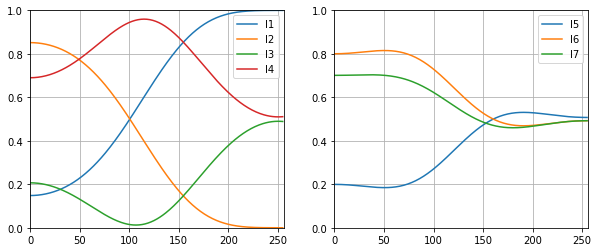

In [21]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(I[0,:], label='I1');
plt.plot(I[1,:], label='I2');
plt.plot(I[2,:], label='I3');
plt.plot(I[3,:], label='I4');
plt.grid('on')
plt.xlim(0,256)
plt.ylim(0,1)
plt.legend()

plt.subplot(1,2,2)
plt.plot(I[4,:], label='I5');
plt.plot(I[5,:], label='I6');
plt.plot(I[6,:], label='I7');
plt.grid('on')
plt.xlim(0,256)
plt.ylim(0,1)
plt.legend()

## Equations 5 and 6

## Comprobación de unicidad

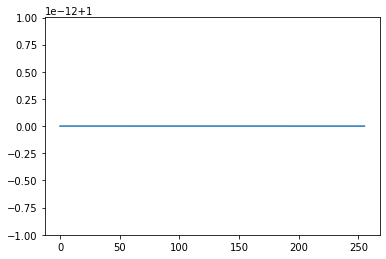

In [22]:
plt.plot(X2+Y2+Z2+W2)

## Figure 3

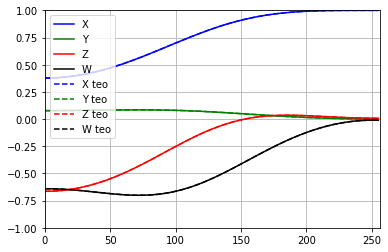

In [23]:
plt.figure()
plt.plot(X, 'b', label='X')
plt.plot(Y, 'g', label='Y')
plt.plot(Z, 'r', label='Z')
plt.plot(W, 'k', label='W')

plt.plot(X_teo, 'b--', label='X teo')
plt.plot(Y_teo, 'g--', label='Y teo')
plt.plot(Z_teo, 'r--', label='Z teo')
plt.plot(W_teo, 'k--', label='W teo')
plt.grid('on')
plt.xlim(0,256)
plt.ylim(-1,1)
plt.legend()

## Comparison between Jones matrices: From definition and from Moreno "experiment"

In [24]:
J00_exp=X-1j*Y
J01_exp=Z-1j*W
J10_exp=-Z-1j*W
J11_exp=X+1j*Y

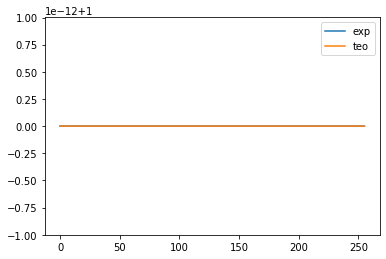

In [25]:
LCD_experimental=Jones_matrix('experimental')
LCD_experimental.from_components((J00_exp,J01_exp,J10_exp,J11_exp));
det_exp=np.abs(LCD_experimental.parameters.det())
plt.plot(det_exp, label='exp')
plt.plot(det_teo, label='teo')
plt.legend()

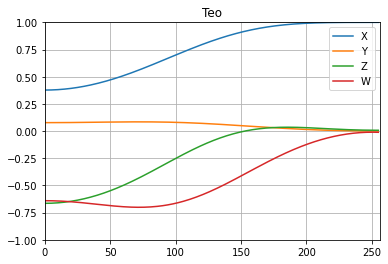

In [26]:
plt.figure()
plt.plot(X_teo, label='X')
plt.plot(Y_teo, label='Y')
plt.plot(Z_teo, label='Z')
plt.plot(W_teo, label='W')
plt.grid('on')
plt.xlim(0,256)
plt.ylim(-1,1)
plt.title('Teo')
plt.legend()

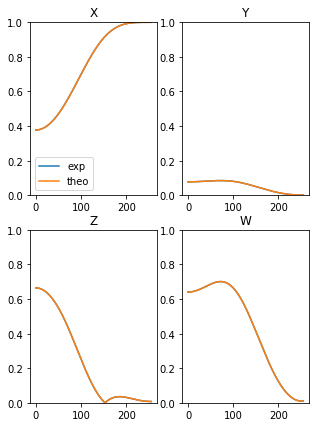

In [27]:
plt.figure(figsize=(5,7))
plt.subplot(2,2,1)
plt.title('X')
plt.plot(np.abs(X), label='exp')
plt.plot(np.abs(X_teo), label='theo')
plt.ylim(0,1)
plt.legend()

plt.subplot(2,2,2)
plt.title('Y')
plt.plot(np.abs(Y))
plt.plot(np.abs(Y_teo))
plt.ylim(0,1)

plt.subplot(2,2,3)
plt.title('Z')
plt.plot(np.abs(Z))
plt.plot(np.abs(Z_teo))
plt.ylim(0,1)

plt.subplot(2,2,4)
plt.title('W')
plt.plot(np.abs(W))
plt.plot(np.abs(W_teo))
plt.ylim(0,1);


Text(0.5, 0.98, 'abs()')

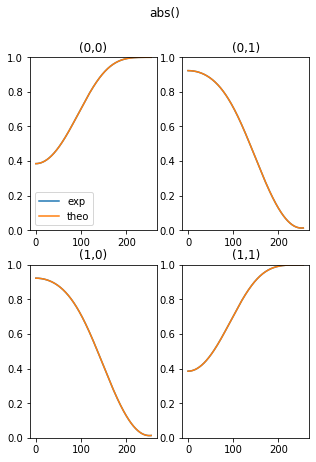

In [28]:
plt.figure(figsize=(5,7))
plt.subplot(2,2,1)
plt.title('(0,0)')
plt.plot(np.abs(J00_exp), label='exp')
plt.plot(np.abs(J00_teo), label='theo')
plt.legend()
plt.ylim(0,1)

plt.subplot(2,2,2)
plt.title('(0,1)')
plt.plot(np.abs(J01_exp))
plt.plot(np.abs(J01_teo))
plt.ylim(0,1)

plt.subplot(2,2,3)
plt.title('(1,0)')
plt.plot(np.abs(J10_exp))
plt.plot(np.abs(J10_teo))
plt.ylim(0,1)

plt.subplot(2,2,4)
plt.title('(1,1)')
plt.plot(np.abs(J11_exp))
plt.plot(np.abs(J11_teo))
plt.ylim(0,1)

plt.suptitle('abs()')

Text(0.5, 0.98, 'angles')

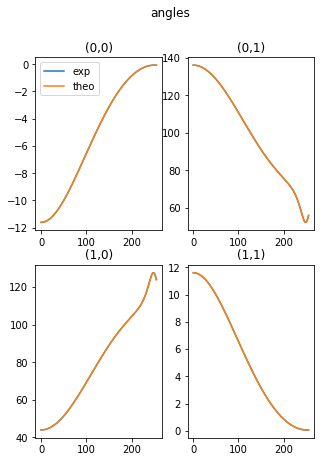

In [29]:
plt.figure(figsize=(5,7))
plt.subplot(2,2,1)
plt.title('(0,0)')
plt.plot(np.angle(J00_exp)/degrees, label='exp')
plt.plot(np.angle(J00_teo)/degrees, label='theo')
plt.legend()

plt.subplot(2,2,2)
plt.title('(0,1)')
plt.plot(np.angle(J01_exp)/degrees)
plt.plot(np.angle(J01_teo)/degrees)

plt.subplot(2,2,3)
plt.title('(1,0)')
plt.plot(np.angle(J10_exp)/degrees)
plt.plot(np.angle(J10_teo)/degrees)

plt.subplot(2,2,4)
plt.title('(1,1)')
plt.plot(np.angle(J11_exp)/degrees)
plt.plot(np.angle(J11_teo)/degrees)

plt.suptitle('angles')